<a href="https://colab.research.google.com/github/ashishpatel26/DeepAnT-A-Deep-Learning-Approach-for-Unsupervised-Anomaly-Detection-in-Time-Series/blob/main/DeepAnT_A_Deep_Learning_Approach_for_Unsupervised_Anomaly_Detection_in_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/50
24/24 - 4s - loss: 0.0883 - val_loss: 0.0875 - 4s/epoch - 152ms/step
Epoch 2/50
24/24 - 0s - loss: 0.0505 - val_loss: 0.0684 - 228ms/epoch - 10ms/step
Epoch 3/50
24/24 - 0s - loss: 0.0422 - val_loss: 0.0852 - 177ms/epoch - 7ms/step
Epoch 4/50
24/24 - 0s - loss: 0.0385 - val_loss: 0.0824 - 188ms/epoch - 8ms/step
Epoch 5/50
24/24 - 0s - loss: 0.0343 - val_loss: 0.0415 - 152ms/epoch - 6ms/step
Epoch 6/50
24/24 - 0s - loss: 0.0325 - val_loss: 0.0482 - 188ms/epoch - 8ms/step
Epoch 7/50
24/24 - 0s - loss: 0.0305 - val_loss: 0.0415 - 325ms/epoch - 14ms/step
Epoch 8/50
24/24 - 0s - loss: 0.0303 - val_loss: 0.0394 - 211ms/epoch - 9ms/step
Epoch 9/50
24/24 - 0s - loss: 0.0299 - val_loss: 0.0408 - 169ms/epoch - 7ms/step
Epoch 10/50
24/24 - 0s - loss: 0.0296 - val_loss: 0.0471 - 112ms/epoch - 5ms/step
Epoch 11/50
24/24 - 0s - loss: 0.0305 - val_loss: 0.0481 - 110ms/epoch - 5ms/step
Epoch 12/50
24/24 - 0s - loss: 0.0318 - val_loss: 0.0403 - 118ms/epoch - 5ms/step
Epoch 13/50
24/24 - 0s -

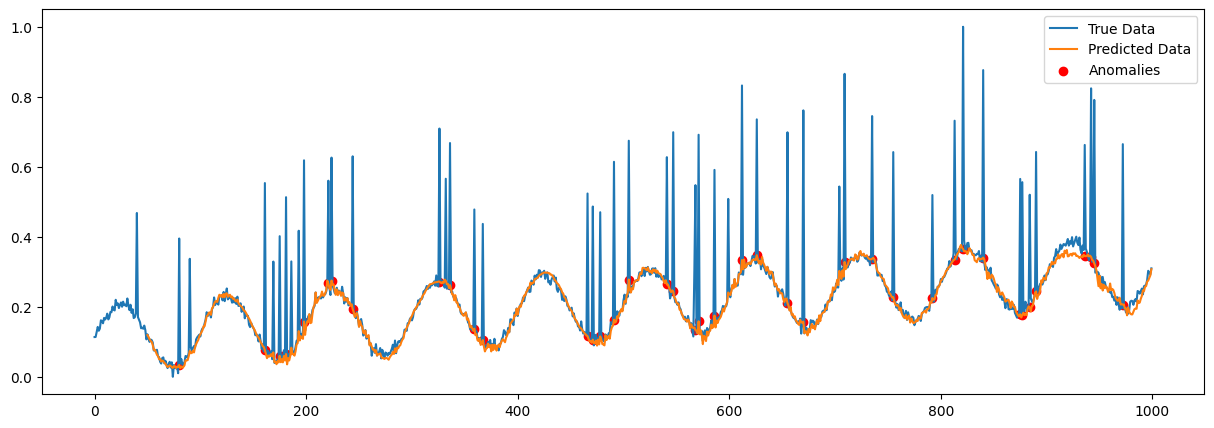

In [3]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

# Load and preprocess data
data = pd.read_csv('synthetic_timeseries_data.csv')
values = data['value'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values)

# Prepare data for CNN
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back):
        X.append(dataset[i:(i+look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 50  # History window size
X, Y = create_dataset(scaled_values, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Define the CNN model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(look_back, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_absolute_error')

# Train the model
model.fit(X, Y, epochs=50, batch_size=32, validation_split=0.2, verbose=2)

# Predict and calculate reconstruction error
predictions = model.predict(X)
reconstruction_error = np.abs(predictions.flatten() - Y.flatten())

# Define the threshold for anomaly detection
mean_error = np.mean(reconstruction_error)
std_error = np.std(reconstruction_error)
threshold = mean_error + 3 * std_error

# Anomaly detection
anomalies = np.where(reconstruction_error > threshold)[0]

# Generate true labels for the synthetic data
true_labels = np.zeros(len(reconstruction_error))
true_labels[anomalies] = 1

# Generate predicted labels based on the threshold
pred_labels = np.zeros(len(reconstruction_error))
pred_labels[reconstruction_error > threshold] = 1

# Calculate precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='binary')
print(f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')

# Plot results
plt.figure(figsize=(15, 5))
plt.plot(scaled_values, label='True Data')
plt.plot(np.arange(look_back, len(predictions) + look_back), predictions, label='Predicted Data')
plt.scatter(anomalies + look_back, predictions[anomalies], color='red', label='Anomalies')
plt.legend()
plt.show()